In [3]:
# Installing required version of pytorch. For Udacity final classification project I am downloading 0.4.1

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
  
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

0.4.1
0.2.1


In [0]:
# Imports here

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import torch
import PIL
from PIL import Image
import matplotlib.gridspec as gridspec
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from collections import OrderedDict
import json
import copy

In [5]:
### Install Pillow 
!pip install -q pillow==4.1.1
print(PIL.PILLOW_VERSION)

4.1.1


In [6]:
# Mount the google drive so that we can save our trained model

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
# Downloading the required data files

!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [0]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = F"/content/gdrive/My Drive/Manjeet PhD/flower_data_original_test"

In [0]:
torch.manual_seed(7)

use_gpu = torch.cuda.is_available()

In [0]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

In [0]:
# Load the datasets with ImageFolder

image_datasets = dict()
image_datasets['train'] = datasets.ImageFolder(train_dir, transform=train_transforms)
image_datasets['valid'] = datasets.ImageFolder(valid_dir, transform=valid_transforms)
image_datasets['test'] = datasets.ImageFolder(test_dir, transform=test_transforms)


Dasaset Size: {'train': 6552, 'valid': 818, 'test': 819}

Number of classes: 102

Classes: ['1', '10', '100', '101', '102', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']

3
224


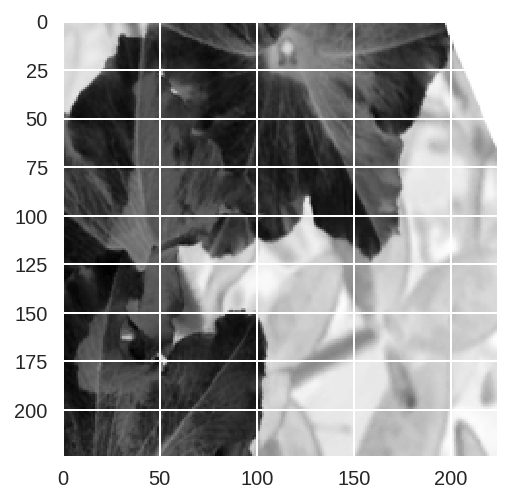

In [12]:
# Using the image datasets and the transforms, define the dataloaders
batch_size = 64
dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True)
dataloaders['test']  = torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)

#Know your data
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

print ("Dasaset Size: "+ str(dataset_sizes) + "\n")
n_class = len(class_names)
print ("Number of classes: "+ str(n_class) + "\n")
print ("Classes: "+ str(class_names) + "\n")

print (len(dataloaders))

class_to_idx = image_datasets['train'].class_to_idx

images, labels = next(iter(dataloaders["train"]))
print(len(images[0,2]))
plt.imshow(images[0,0])

In [0]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [0]:
def get_densenet_model(hidden_units):
    model = models.densenet121(pretrained=True)

   # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    # Replace classifier, ensure input and output sizes match
    classifier_input_size = model.classifier.in_features
    classifier_output_size = 102
    
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(classifier_input_size, hidden_units)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(hidden_units, classifier_output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    model.classifier = classifier

    return model

In [0]:
def create_model(learning_rate, hidden_units, class_to_idx):
    ''' Create a deep learning model from existing PyTorch model.
    '''
    # Load pre-trained model
    model = get_densenet_model(hidden_units)

    # Set training parameters
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(parameters, lr=learning_rate)
    criterion = nn.NLLLoss()

    # Save class to index mapping
    model.class_to_idx = class_to_idx

    return model, optimizer, criterion

In [16]:
# Get class to index mapping
class_to_idx = image_datasets['train'].class_to_idx

# Load pretrained model
hidden_units = 512
learning_rate = 0.001
model, optimizer, criterion = create_model(learning_rate, hidden_units, class_to_idx)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [0]:
# Move tensors to GPU if available
if use_gpu:
    model.cuda()
    criterion.cuda()

In [0]:
def validate_model(model, criterion, data_loader):
    # Put model in inference mode
    model.eval()

    accuracy = 0
    test_loss = 0
    for inputs, labels in iter(data_loader):

        if use_gpu:
            inputs = Variable(inputs.float().cuda())
            labels = Variable(labels.long().cuda()) 
        else:
            inputs = Variable(inputs)
            labels = Variable(labels)

        output = model.forward(inputs)
        test_loss += criterion(output, labels).data[0]

        # Model's output is log-softmax,
        # take exponential to get the probabilities
        ps = torch.exp(output).data

        # Class with highest probability is our predicted class, 
        equality = (labels.data == ps.max(1)[1])

        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.type_as(torch.FloatTensor()).mean()
        
    return test_loss/len(data_loader), accuracy/len(data_loader)

In [0]:
def train_model(model, criterion, optimizer, epochs, training_data_loader, validation_data_loader):
    # Ensure model in training mode
    model.train()

    # Train the network using training data
    print_every = 40
    steps = 0

    for epoch in range(epochs):
        running_loss = 0

        # Get inputs and labels from training set
        for inputs, labels in iter(training_data_loader):
            steps += 1

            # Move tensors to GPU if available
            if use_gpu:
                inputs = Variable(inputs.float().cuda())
                labels = Variable(labels.long().cuda()) 
            else:
                inputs = Variable(inputs)
                labels = Variable(labels) 

            # Set gradients to zero
            optimizer.zero_grad()

            # Forward pass to calculate logits
            output = model.forward(inputs)
            
            # Calculate loss (how far is prediction from label)
            loss = criterion(output, labels)

            # Backward pass to calculate gradients
            loss.backward()

            # Update weights using optimizer (add gradients to weights)
            optimizer.step()

            # Track the loss as we are training the network
            running_loss += loss.data[0]

            if steps % print_every == 0:
                validation_loss, accuracy = validate_model(model, criterion, validation_data_loader)

                print("Epoch: {}/{} ".format(epoch+1, epochs),
                        "Training Loss: {:.3f} ".format(running_loss/print_every),
                        "Validation Loss: {:.3f} ".format(validation_loss),
                        "Validation Accuracy: {:.3f}".format(accuracy))

                running_loss = 0

                # Put model back in training mode
                model.train()

In [20]:
# Train the network using traning data
total_epochs = 10
train_model(model, criterion, optimizer, total_epochs, dataloaders['train'], dataloaders['valid'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1/10  Training Loss: 3.979  Validation Loss: 2.968  Validation Accuracy: 0.419
Epoch: 1/10  Training Loss: 2.501  Validation Loss: 1.619  Validation Accuracy: 0.655
Epoch: 2/10  Training Loss: 0.586  Validation Loss: 0.993  Validation Accuracy: 0.785
Epoch: 2/10  Training Loss: 1.179  Validation Loss: 0.728  Validation Accuracy: 0.845
Epoch: 2/10  Training Loss: 0.954  Validation Loss: 0.592  Validation Accuracy: 0.863
Epoch: 3/10  Training Loss: 0.648  Validation Loss: 0.486  Validation Accuracy: 0.882
Epoch: 3/10  Training Loss: 0.716  Validation Loss: 0.420  Validation Accuracy: 0.903
Epoch: 4/10  Training Loss: 0.184  Validation Loss: 0.400  Validation Accuracy: 0.902
Epoch: 4/10  Training Loss: 0.615  Validation Loss: 0.350  Validation Accuracy: 0.913
Epoch: 4/10  Training Loss: 0.610  Validation Loss: 0.337  Validation Accuracy: 0.922
Epoch: 5/10  Training Loss: 0.387  Validation Loss: 0.329  Validation Accuracy: 0.907
Epoch: 5/10  Training Loss: 0.521  Validation Loss: 0.

In [21]:
# Do validation on the test set
test_loss, accuracy = validate_model(model, criterion, dataloaders['test'])
print("Validation Accuracy: {:.3f}".format(accuracy))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Validation Accuracy: 0.919


In [0]:
# Save the checkpoint 
checkpoint_path = 'densenet121_checkpoint.pth'
state = {
    'arch': 'densenet121',
    'learning_rate': learning_rate,
    'hidden_units': hidden_units,
    'epochs': total_epochs,
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
    'class_to_idx' : model.class_to_idx
}
torch.save(state, checkpoint_path)